In [1]:
# mengimpor modul-modul yang diperlukan

import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
from IPython.display import display, Math

## 2.0 < z < 2.5, Composite Model

In [7]:
data = np.loadtxt('r2.0z2.5.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

def lnlike(theta, M, phi, phi_err):
    Mca, Mcb, log_phi1a, log_phi2a, log_phi1b, log_phi2b, alpha1a, alpha2a, alpha1b, alpha2b = theta    
    xa = 10**(M-Mca)
    xb = 10**(M-Mcb)    
    model = np.log(10) * np.exp(-xa) * xa * [10**log_phi1a * xa**alpha1a + 10**log_phi2a * xa**alpha2a] + np.log(10) * np.exp(-xb) * xb * [10**log_phi1b * xb**alpha1b + 10**log_phi2b * xb**alpha2b]
    sigma2 = phi_err**2    
    return -0.5 * np.sum((phi - model) ** 2 / sigma2)

def lnprior(theta):
    Mca, Mcb, log_phi1a, log_phi2a, log_phi1b, log_phi2b, alpha1a, alpha2a, alpha1b, alpha2b = theta
    if ( 9.5 < Mca < 12.0 ) & ( 7.5 < Mcb < 9.5 ) & (log_phi2a-log_phi1a < np.log10(0.5)) & (log_phi2b-log_phi1b < np.log10(0.5))  & (log_phi2a > -7.5) & (log_phi2b > -8.5) & ( -3.0 < alpha1a < 1.5) & ( -3.0 < alpha2a < -1.0 ) &  ( -3.0 < alpha1b < 3.0) & ( -4.0 < alpha2b < 0.0 ):
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta, M, phi, phi_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, M, phi, phi_err)

resultcom = [10.573, 8.254, -3.856, -7.276, -5.433, -7.656, 0.181, -1.097, 2.925, -1.835]
data = (log_mass, phi, phi_err)
nwalkers = 100
niter = 10000
initial = [10.54, 8.75, -3.92, -6.88, -4.2, -7, 0.46, -1.3, 1.5, -1.3]
initial = resultcom
ndim = len(initial)

p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


100%|██████████████████████████████████| 100/100 [00:00<00:00, 108.26it/s]


Running production...


100%|██████████████████████████████| 10000/10000 [01:09<00:00, 144.42it/s]


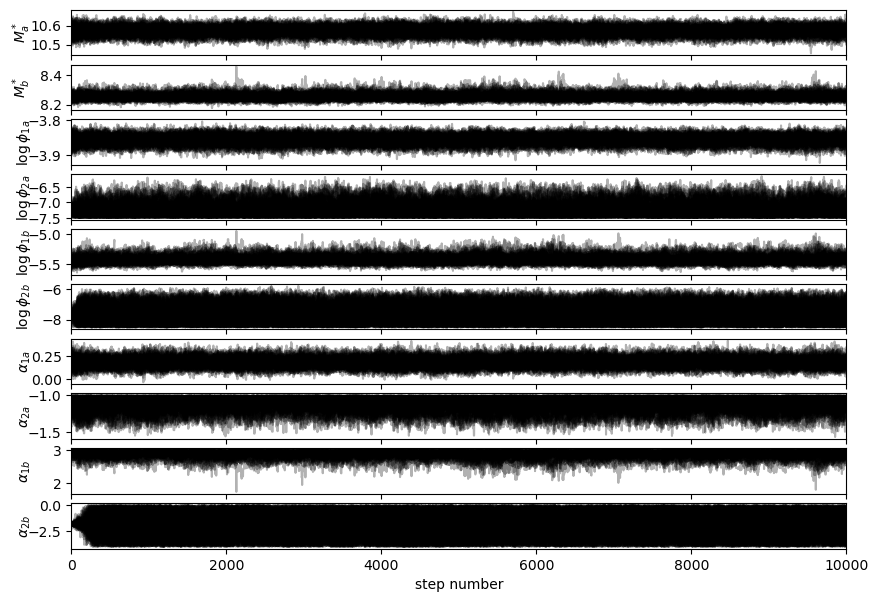

In [8]:
# membuat trace plot

fig, axes = plt.subplots(10, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r'$M^*_a$', r'$M^*_b$', r'$\log{\phi_1}_a$', r'$\log{\phi_2}_a$', r'$\log{\phi_1}_b$', r'$\log{\phi_2}_b$', r'$\alpha_{1a}$', r'$\alpha_{2a}$', r'$\alpha_{1b}$', r'$\alpha_{2b}$']

for i in range(10):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number")
plt.savefig('rumput_2_z_25.png')

(66000, 10)


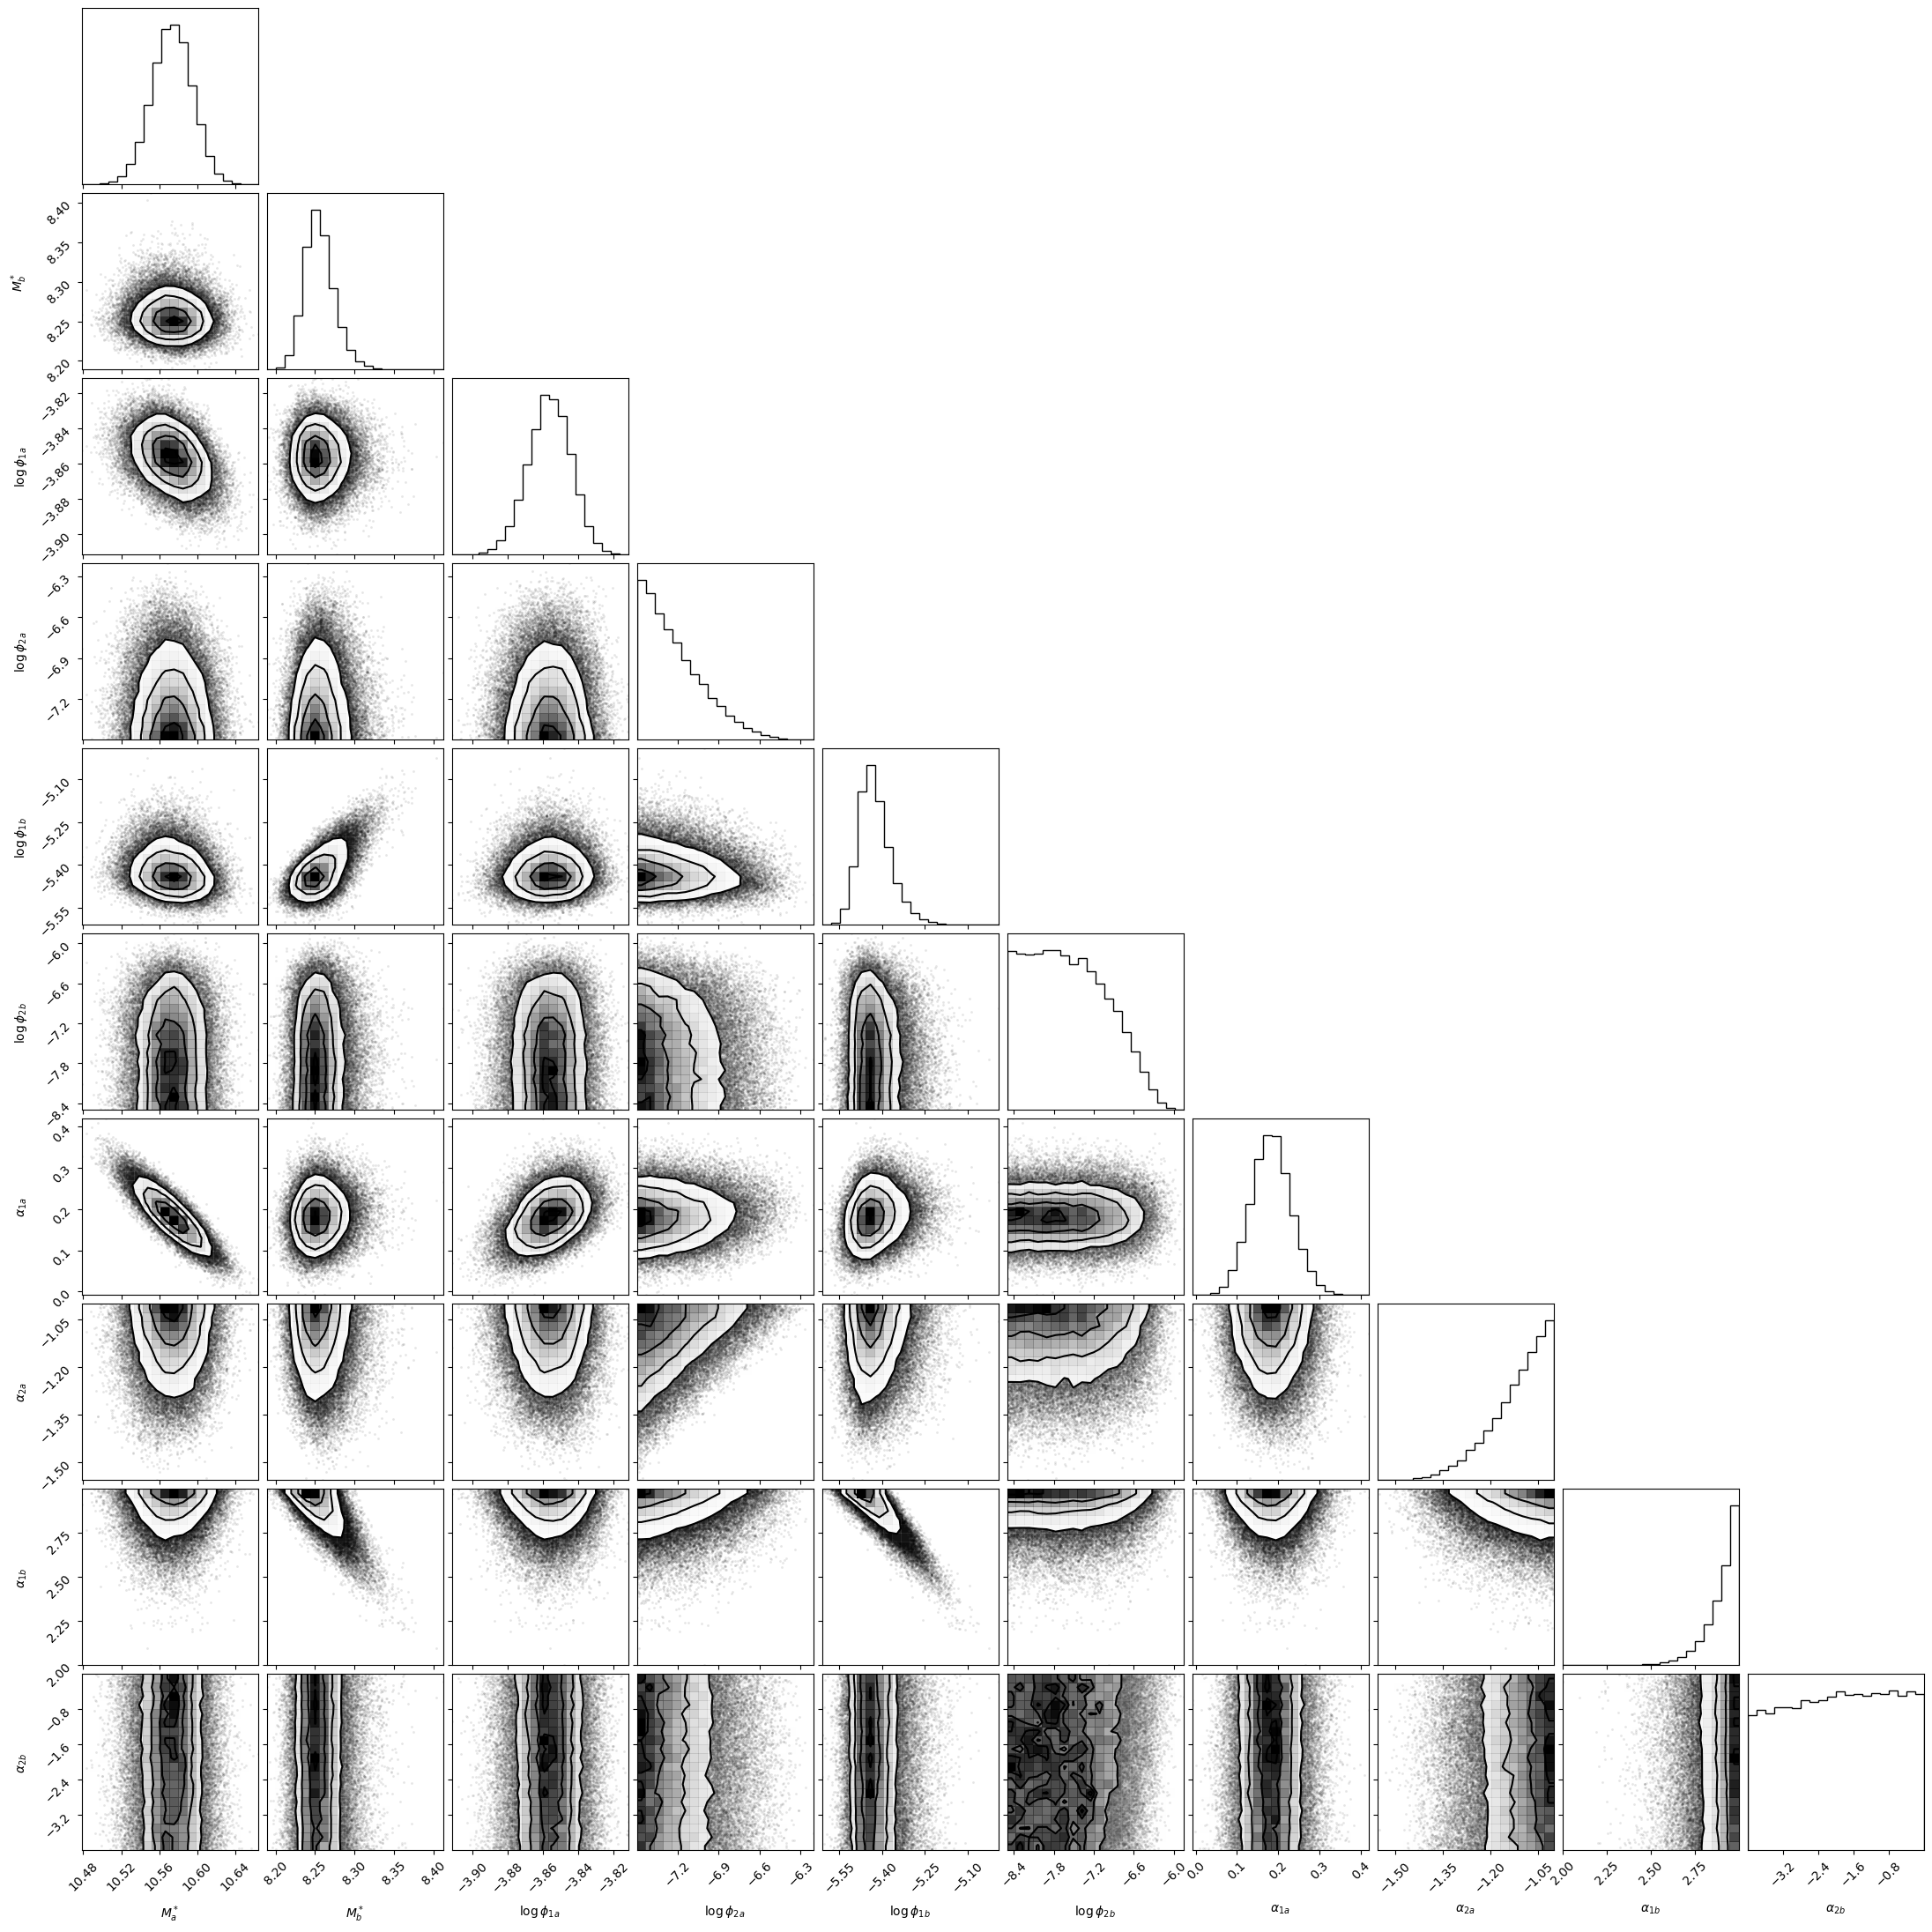

In [9]:
# membuat corner plot

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels)
fig.savefig('cornet_2_z_25.svg')

In [10]:
# parameter hasil fitting

labels = [r'M^*_a', r'M^*_b', r'\log{\phi_1}_a', r'\log{\phi_2}_a', r'\log{\phi_1}_b', r'\log{\phi_2}_b', r'\alpha_{1a}', r'\alpha_{2a}', r'\alpha_{1b}', r'\alpha_{2b}']

resultcom = []
resultcom_low = []
resultcom_high = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    resultcom.append(mcmc[1])
    resultcom_low.append(mcmc[0])
    resultcom_high.append(mcmc[2])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

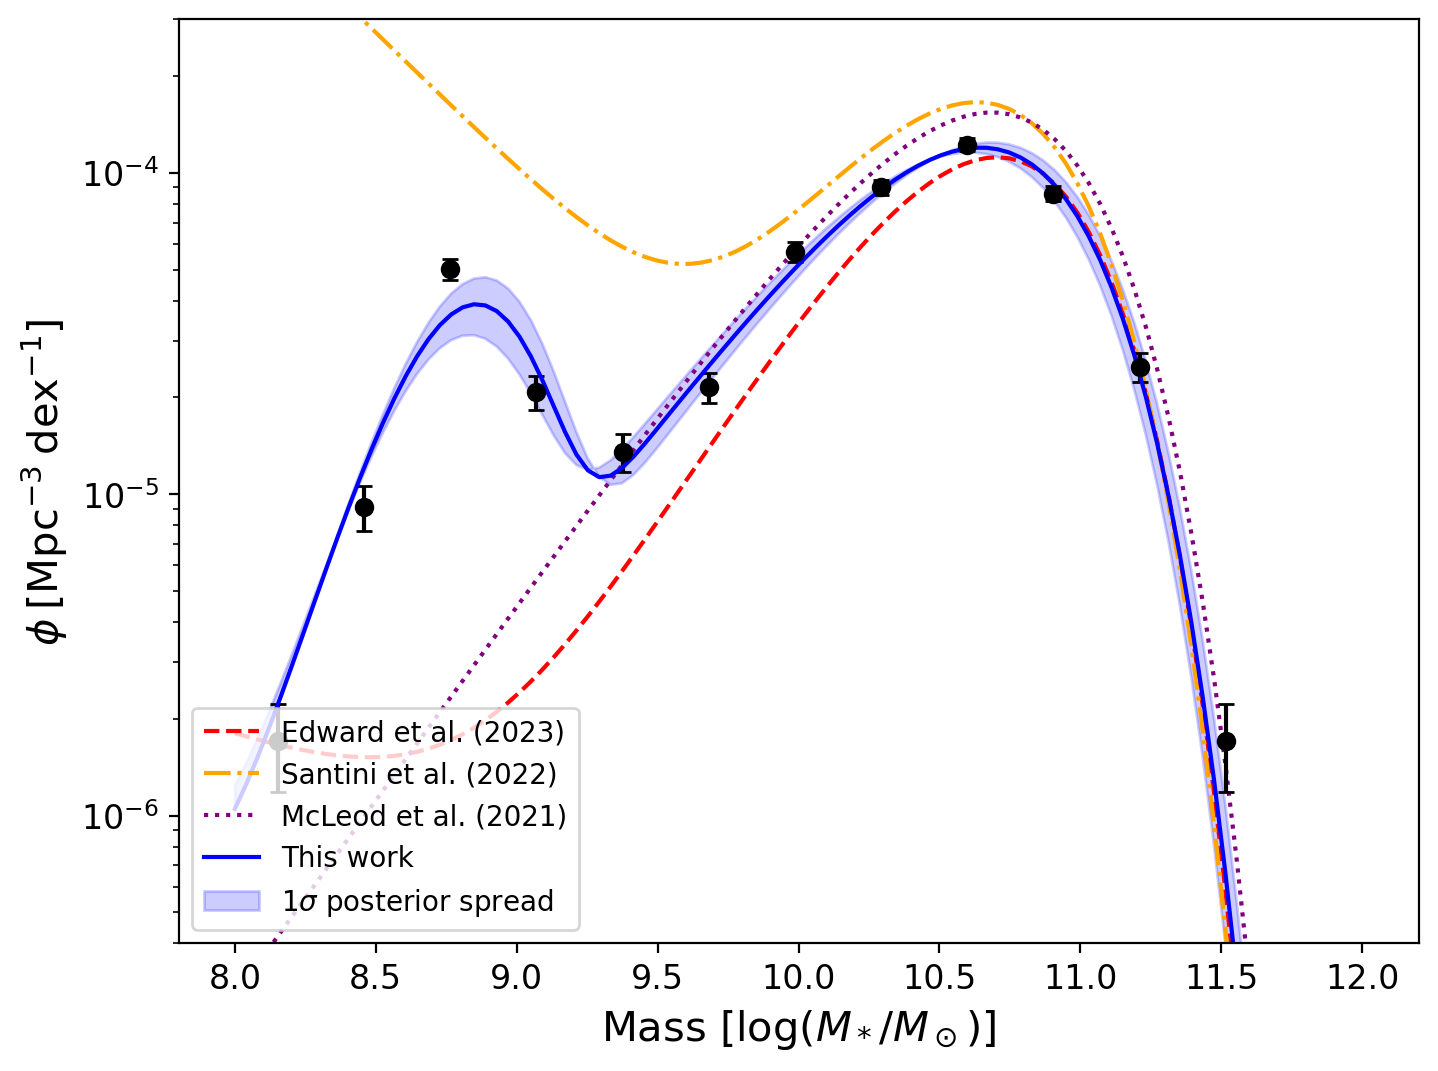

In [11]:
def phi_func_double(M, theta):
    
    Mca = theta[0]
    Mcb = theta[1]
    log_phi1a = theta[2]
    log_phi2a = theta[3]
    log_phi1b = theta[4]
    log_phi2b = theta[5]
    alpha1a = theta[6]
    alpha2a = theta[7]
    alpha1b = theta[8]
    alpha2b = theta[9]
    
    xa = 10**(M-Mca)
    xb = 10**(M-Mcb)
    
    model = np.log(10) * np.exp(-xa) * xa * [10**log_phi1a * xa**alpha1a + 10**log_phi2a * xa**alpha2a] + np.log(10) * np.exp(-xb) * xb * [10**log_phi1b * xb**alpha1b + 10**log_phi2b * xb**alpha2b]
    return model

def phi_func(M, theta):
    
    Mc = theta[0]
    log_phi1 = theta[1]
    log_phi2 = theta[2]
    alpha1 = theta[3]
    alpha2 = theta[4]

    x = 10**(M-Mc)

    return np.log(10) * np.exp(-x) * x * [10**log_phi1 * x**alpha1 + 10**log_phi2 * x**alpha2]

edward = [10.54, -3.92, -6.88, 0.46, -1.30]
santini = [10.52, -3.73, -5.64, 0.31, -1.85]
mcleod = [10.60, -3.75, -np.inf, 0.22, 0]

data = np.loadtxt('r2.0z2.5.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

plt.figure(figsize=(8,6), dpi = 200)

mass = np.linspace(8,12,100)

plt.plot(mass,phi_func(mass, edward)[0], c = 'red', linestyle='--',label='Edward et al. (2023)')
plt.plot(mass,phi_func(mass, santini)[0], c = 'orange', linestyle='-.',label='Santini et al. (2022)')
plt.plot(mass,phi_func(mass, mcleod)[0], c = 'purple', linestyle='dotted',label='McLeod et al. (2021)')

plt.errorbar(log_mass, phi, yerr=phi_err, fmt='o', capsize=3, markersize=6, linestyle='None', c = 'black')
plt.plot(mass,phi_func_double(mass, resultcom)[0], c = 'blue', linestyle='-',label='This work')
plt.fill_between(mass, phi_func_double(mass, resultcom_low)[0], phi_func_double(mass, resultcom_high)[0], color='blue', alpha=0.2, label=r'$1\sigma$ posterior spread')
plt.xlabel(r'Mass [log$(M_*/M_\odot)]$', size=15)
plt.ylabel(r'$\phi\: [\text{Mpc}^{-3}\: \text{dex}^{-1}]$', size=15)
plt.tick_params(axis='both', which='both', labelsize=12)
plt.yscale('log')
plt.legend(loc='lower left')

plt.ylim(4e-7, 3e-4)
plt.show()

## 2.5 < z < 3.0

In [17]:
data = np.loadtxt('r2.5z3.0.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

def lnlike(theta, M, phi, phi_err):
    Mc, log_phi1, log_phi2, alpha1, alpha2 = theta
    x = 10**(M-Mc)
    model = np.log(10) * np.exp(-x) * x * [10**log_phi1 * x**alpha1 + 10**log_phi2 * x**alpha2]
    sigma2 = phi_err**2
    return -0.5 * np.sum((phi - model) ** 2 / sigma2)

def lnprior(theta):
    Mc, log_phi1, log_phi2, alpha1, alpha2 = theta    
    if ( 9.5 < Mc < 12.0 ) & (log_phi2-log_phi1 < np.log10(0.5)) & (log_phi2 > -7.5) & ( -3.0 < alpha1 < 1.5) & ( -3.0 < alpha2 < -1.0 ):
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta, M, phi, phi_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, M, phi, phi_err)

data = (log_mass, phi, phi_err)
nwalkers = 100
niter = 10000
initial = [10.54, (-3.92), (-6.88), 0.4, -1.89]
initial = result2
ndim = len(initial)

p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


100%|██████████████████████████████████| 100/100 [00:00<00:00, 159.58it/s]


Running production...


100%|██████████████████████████████| 10000/10000 [00:58<00:00, 171.30it/s]


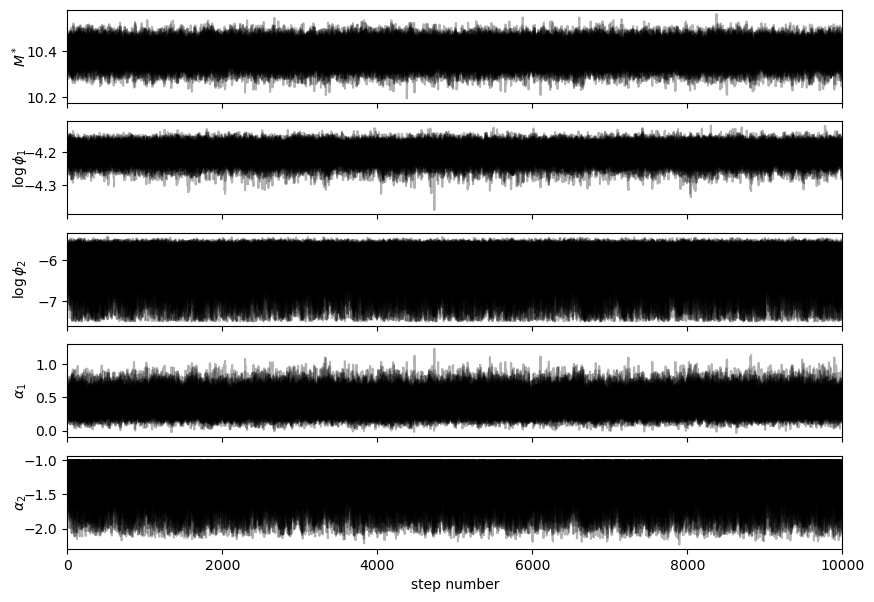

In [19]:
# membuat trace plot

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r'$M^*$', r'$\log{\phi_1}$', r'$\log{\phi_2}$', r'$\alpha_1$', r'$\alpha_2$']

for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number")
plt.savefig('rumput_25_z_30.png')

(66000, 5)


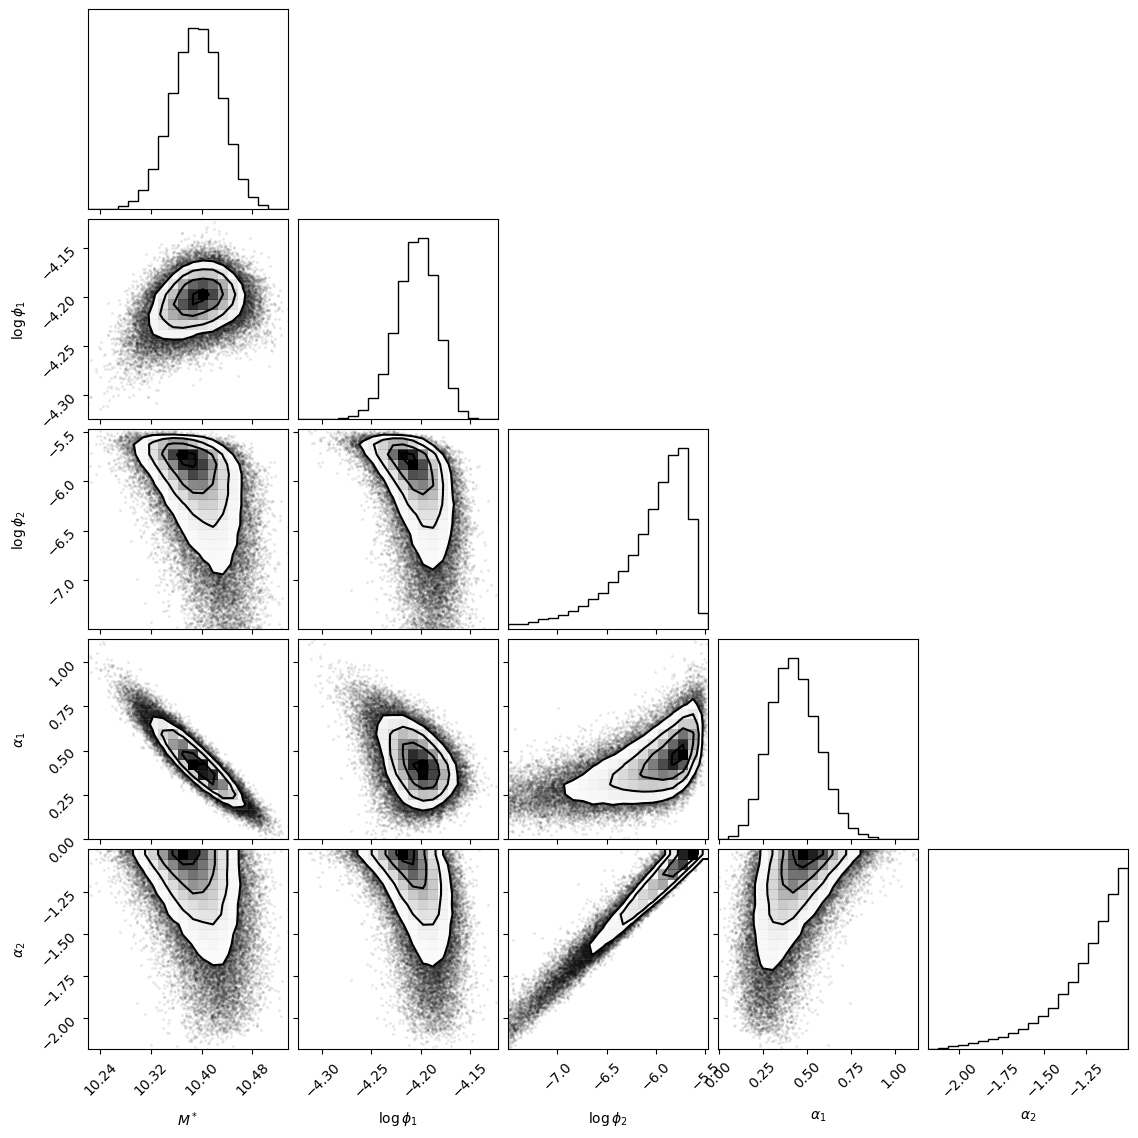

In [20]:
# membuat corner plot

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels)
fig.savefig('cornet_25_z_30.png')

In [21]:
# parameter hasil fitting

labels = [r'M^*', r'log{\phi_1}', r'log{\phi_2}', r'\alpha_1', r'\alpha_2']

result2 = []
result2_low = []
result2_high = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    result2.append(mcmc[1])
    result2_low.append(mcmc[0])
    result2_high.append(mcmc[2])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

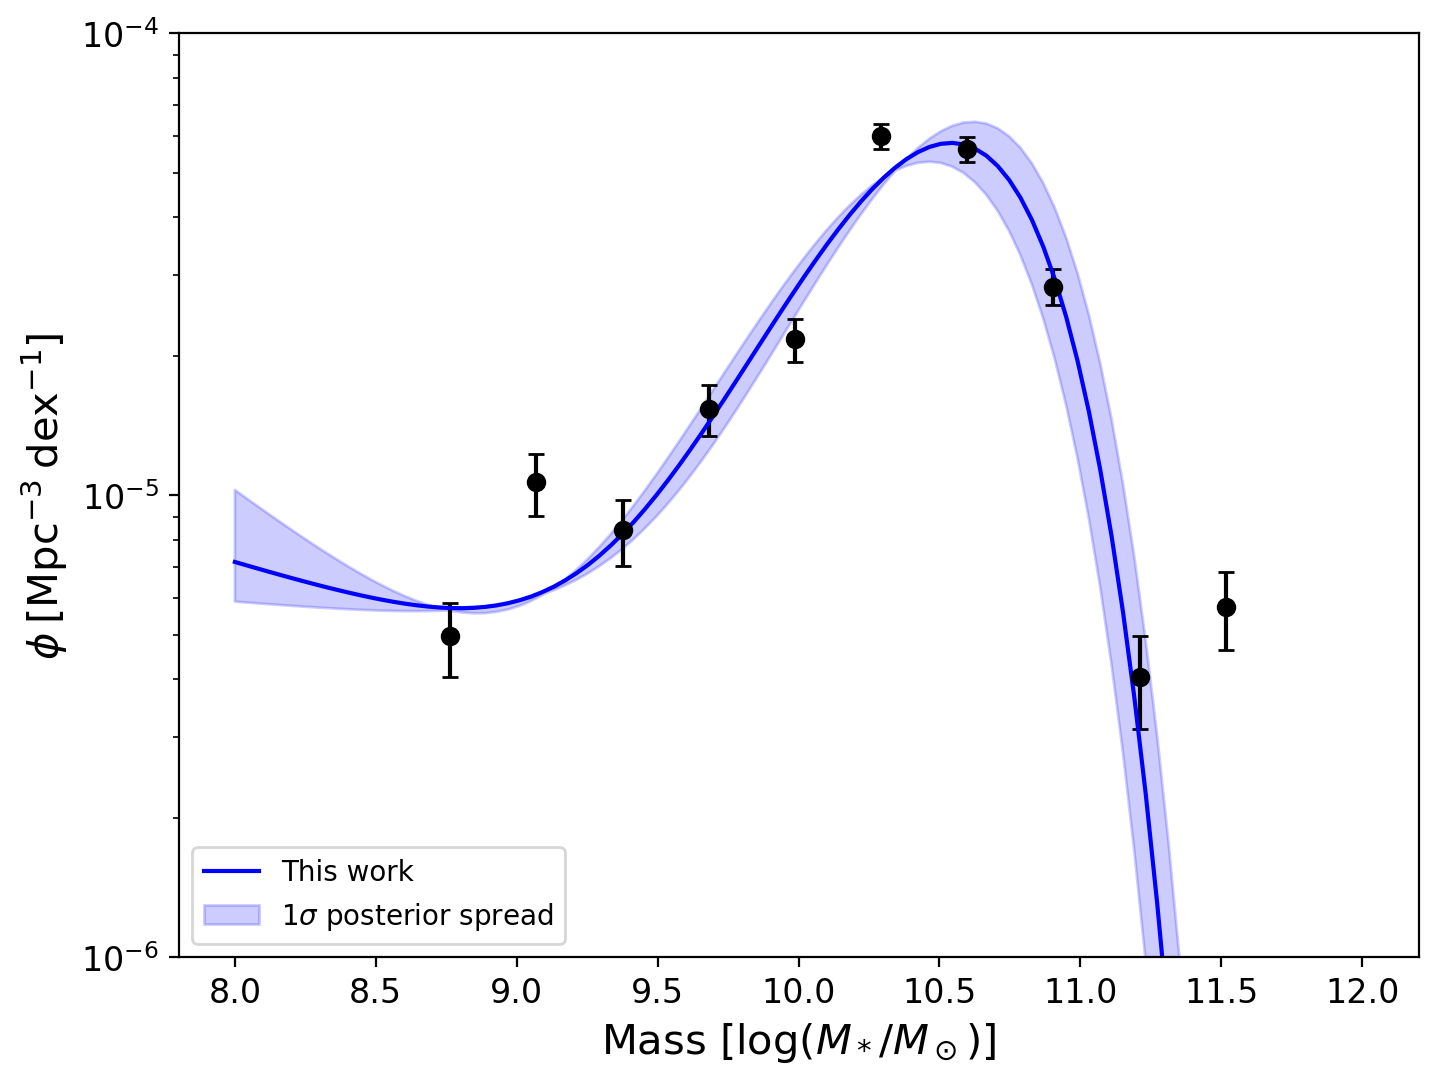

In [22]:
def phi_func(M, theta):
    
    Mc = theta[0]
    log_phi1 = theta[1]
    log_phi2 = theta[2]
    alpha1 = theta[3]
    alpha2 = theta[4]

    x = 10**(M-Mc)

    return np.log(10) * np.exp(-x) * x * [10**log_phi1 * x**alpha1 + 10**log_phi2 * x**alpha2]

data = np.loadtxt('r2.5z3.0.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

plt.figure(figsize=(8,6), dpi = 200)

mass = np.linspace(8,12,100)
plt.errorbar(log_mass, phi, yerr=phi_err, fmt='o', capsize=3, markersize=6, linestyle='None', c = 'black')
plt.plot(mass,phi_func(mass, result2)[0], c = 'blue', linestyle='-',label='This work')
plt.fill_between(mass, phi_func(mass, result2_low)[0], phi_func(mass, result2_high)[0], color='blue', alpha=0.2, label=r'$1\sigma$ posterior spread')
plt.xlabel(r'Mass [log$(M_*/M_\odot)]$', size=15)
plt.ylabel(r'$\phi\: [\text{Mpc}^{-3}\: \text{dex}^{-1}]$', size=15)
plt.tick_params(axis='both', which='both', labelsize=12)
plt.yscale('log')
plt.legend(loc='lower left')

plt.ylim(1e-6, 1e-4)
plt.show()

## 3.0 < z < 3.5

In [28]:
data = np.loadtxt('r3.0z3.5.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

def lnprior(theta):
    Mc, log_phi1, log_phi2, alpha1, alpha2 = theta
    if ( 9.5 < Mc < 12.0 ) & (log_phi2-log_phi1 < np.log10(0.5)) & (log_phi2 > -7.5) & ( -3.0 < alpha1 < 1.5) & ( -3.0 < alpha2 < -1.0 ):
        return 0.0
    else:
        return -np.inf

data = (log_mass, phi, phi_err)
nwalkers = 100
niter = 10000
initial = [10.54, (-3.92), (-6.88), 0.5, -1.30]
initial = result3

ndim = len(initial)

p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


100%|██████████████████████████████████| 100/100 [00:00<00:00, 162.35it/s]


Running production...


100%|██████████████████████████████| 10000/10000 [00:53<00:00, 187.47it/s]


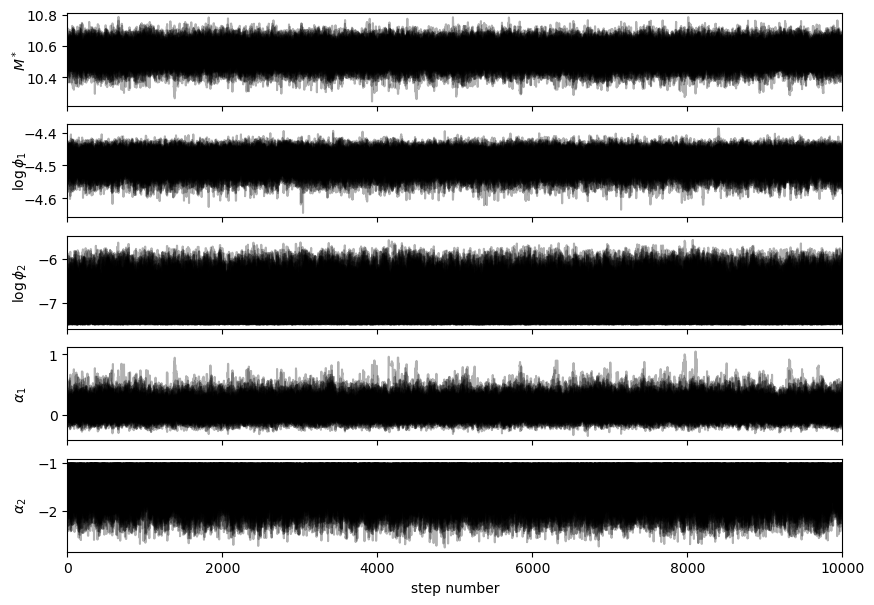

In [30]:
# membuat trace plot

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r'$M^*$', r'$\log{\phi_1}$', r'$\log{\phi_2}$', r'$\alpha_1$', r'$\alpha_2$']

for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number")
plt.savefig('rumput_30_z_35.png')

(66000, 5)


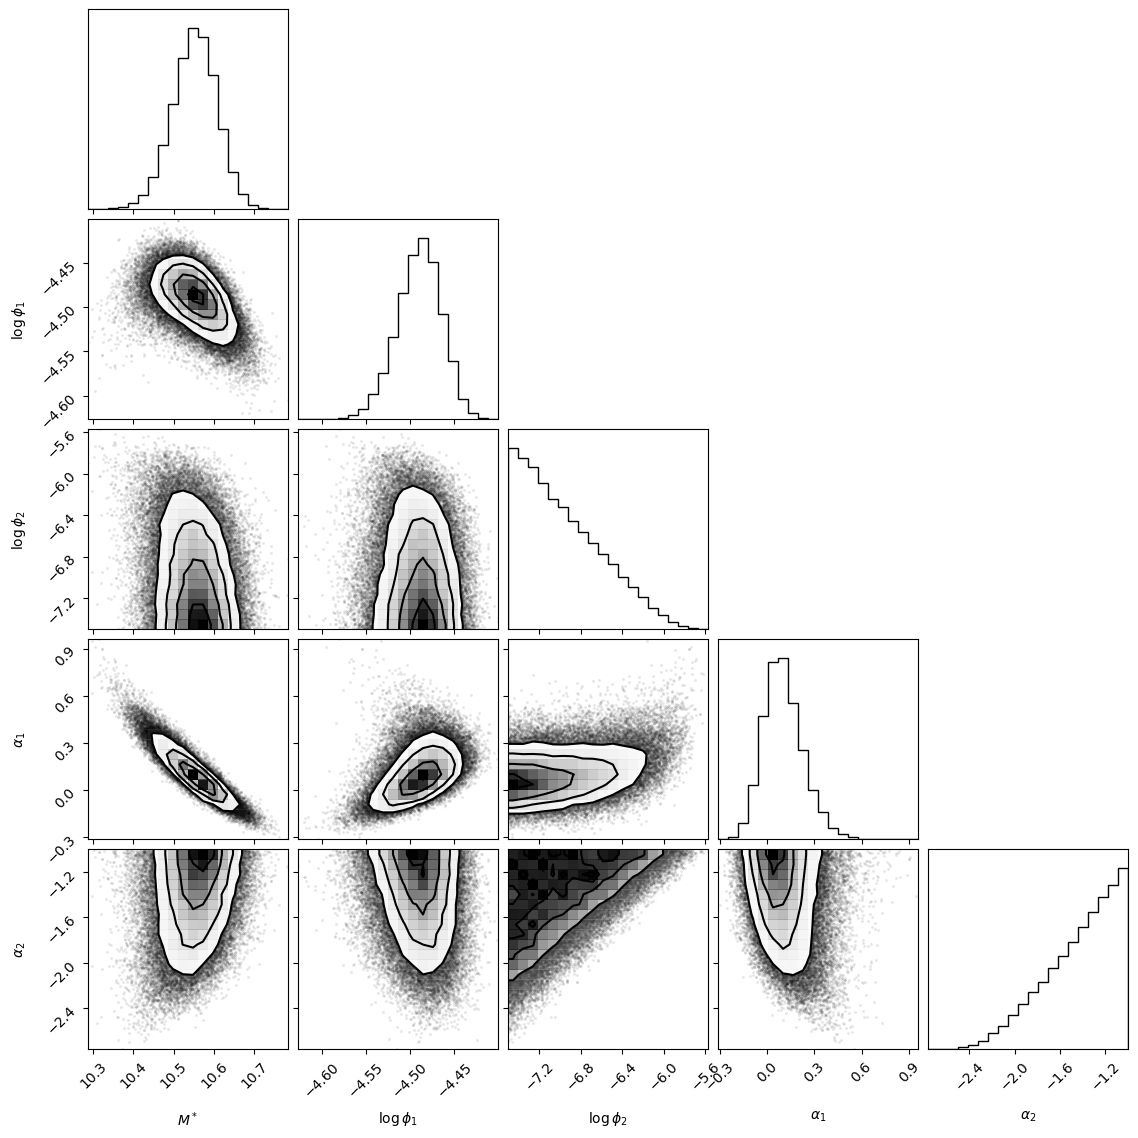

In [31]:
# membuat corner plot

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels)
fig.savefig('cornet_30_z_35.png')

In [32]:
# parameter hasil fitting

labels = [r'M^*', r'log{\phi_1}', r'log{\phi_2}', r'\alpha_1', r'\alpha_2']

result3 = []
result3_low = []
result3_high = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    result3.append(mcmc[1])
    result3_low.append(mcmc[0])
    result3_high.append(mcmc[2])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

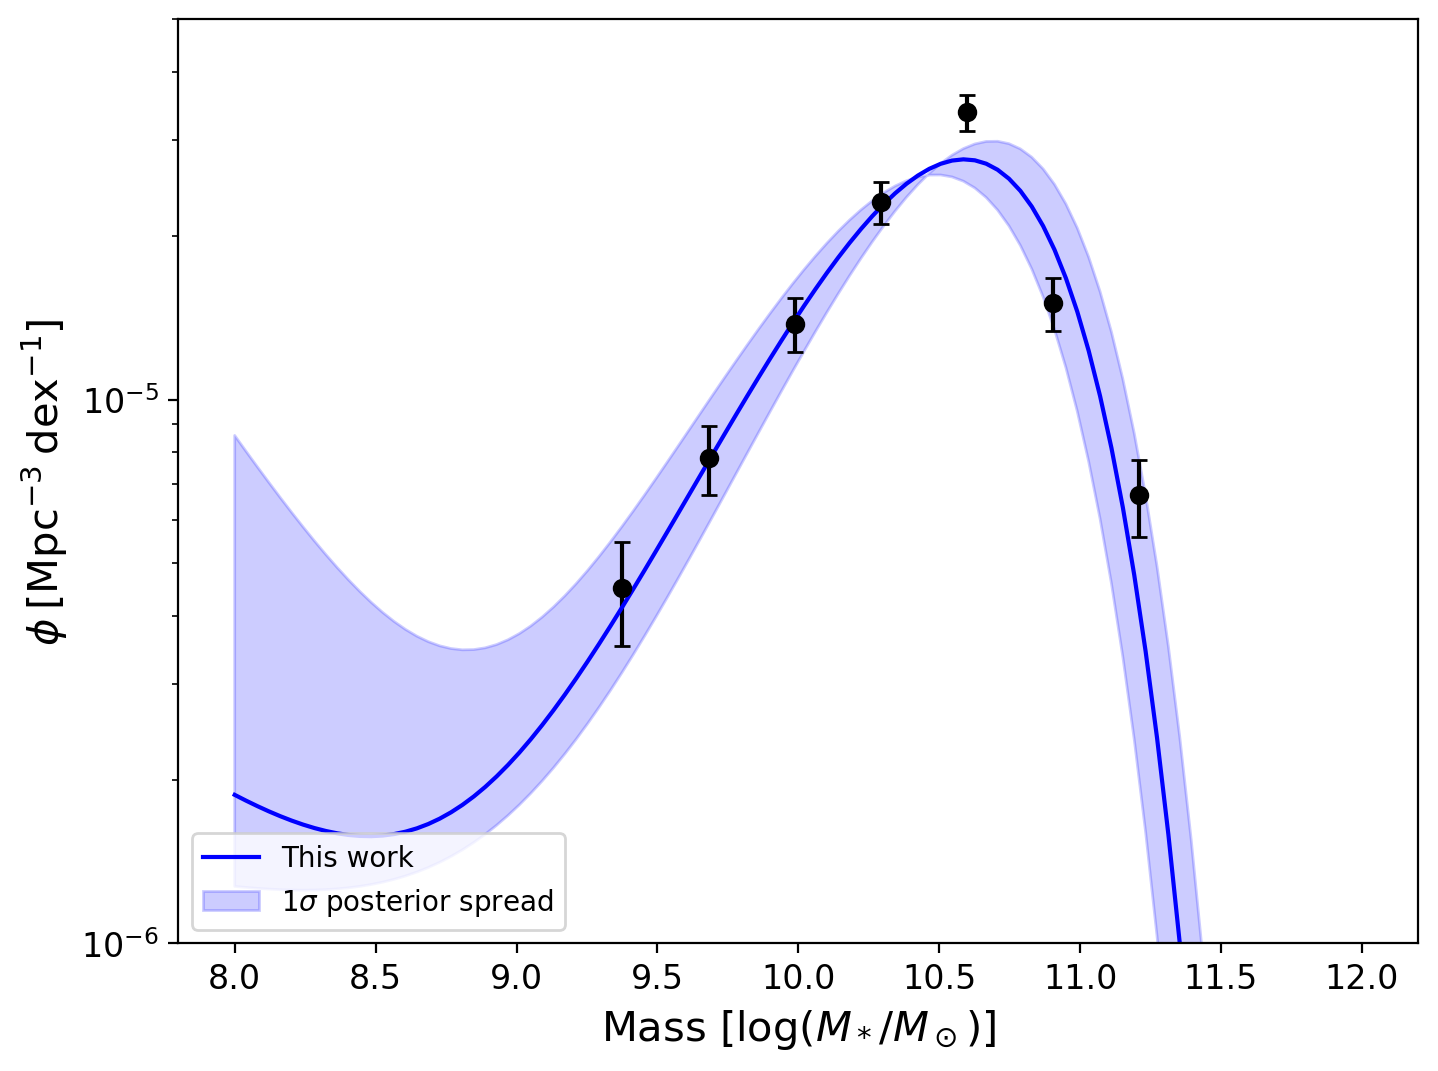

In [33]:
data = np.loadtxt('r3.0z3.5.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

plt.figure(figsize=(8,6), dpi = 200)

mass = np.linspace(8,12,100)
plt.errorbar(log_mass, phi, yerr=phi_err, fmt='o', capsize=3, markersize=6, linestyle='None', c = 'black')
plt.plot(mass,phi_func(mass, result3)[0], c = 'blue', linestyle='-',label='This work')
plt.fill_between(mass, phi_func(mass, result3_low)[0], phi_func(mass, result3_high)[0], color='blue', alpha=0.2, label=r'$1\sigma$ posterior spread')
plt.xlabel(r'Mass [log$(M_*/M_\odot)]$', size=15)
plt.ylabel(r'$\phi\: [\text{Mpc}^{-3}\: \text{dex}^{-1}]$', size=15)
plt.tick_params(axis='both', which='both', labelsize=12)
plt.yscale('log')
plt.legend(loc='lower left')

plt.ylim(1e-6,5e-5)
plt.show()

## 3.5 < z < 4.5

In [39]:
data = np.loadtxt('r3.5z4.0.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

def lnprior(theta):
    Mc, log_phi1, log_phi2, alpha1, alpha2 = theta
    if ( 9.5 < Mc < 12.0 ) & (log_phi2-log_phi1 < np.log10(0.5)) & (log_phi2 > -8.5) & ( -3.0 < alpha1 < 3.0) & ( -3.0 < alpha2 < -1.0 ):
        return 0.0
    else:
        return -np.inf
    
data = (log_mass, phi, phi_err)
nwalkers = 100
niter = 10000
initial = [10.2, -5, -8, 1, -1.1]
initial = result4
ndim = len(initial)

p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


100%|██████████████████████████████████| 100/100 [00:00<00:00, 119.75it/s]


Running production...


100%|██████████████████████████████| 10000/10000 [00:57<00:00, 174.22it/s]


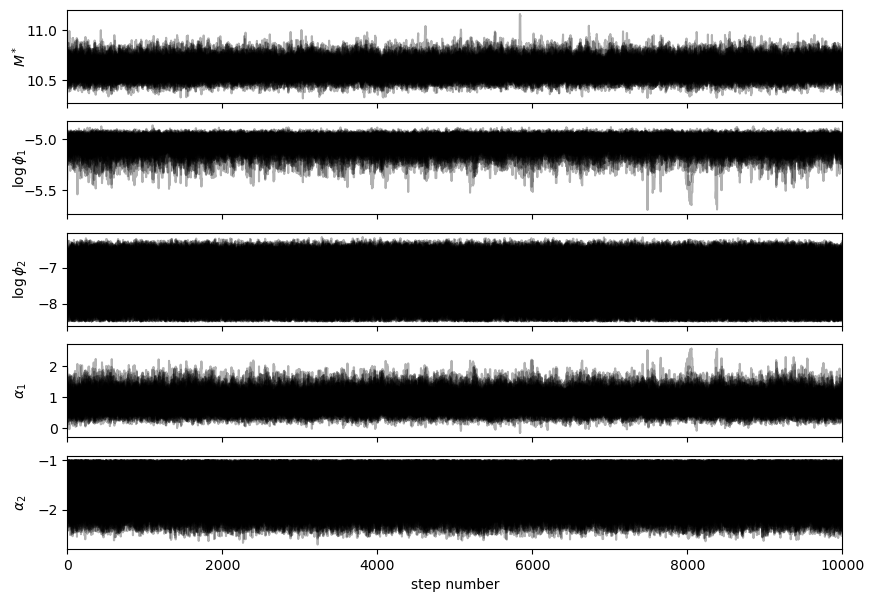

In [40]:
# membuat trace plot

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r'$M^*$', r'$\log{\phi_1}$', r'$\log{\phi_2}$', r'$\alpha_1$', r'$\alpha_2$']

for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number")
plt.savefig('rumput_35_z_45.png')

(66000, 5)


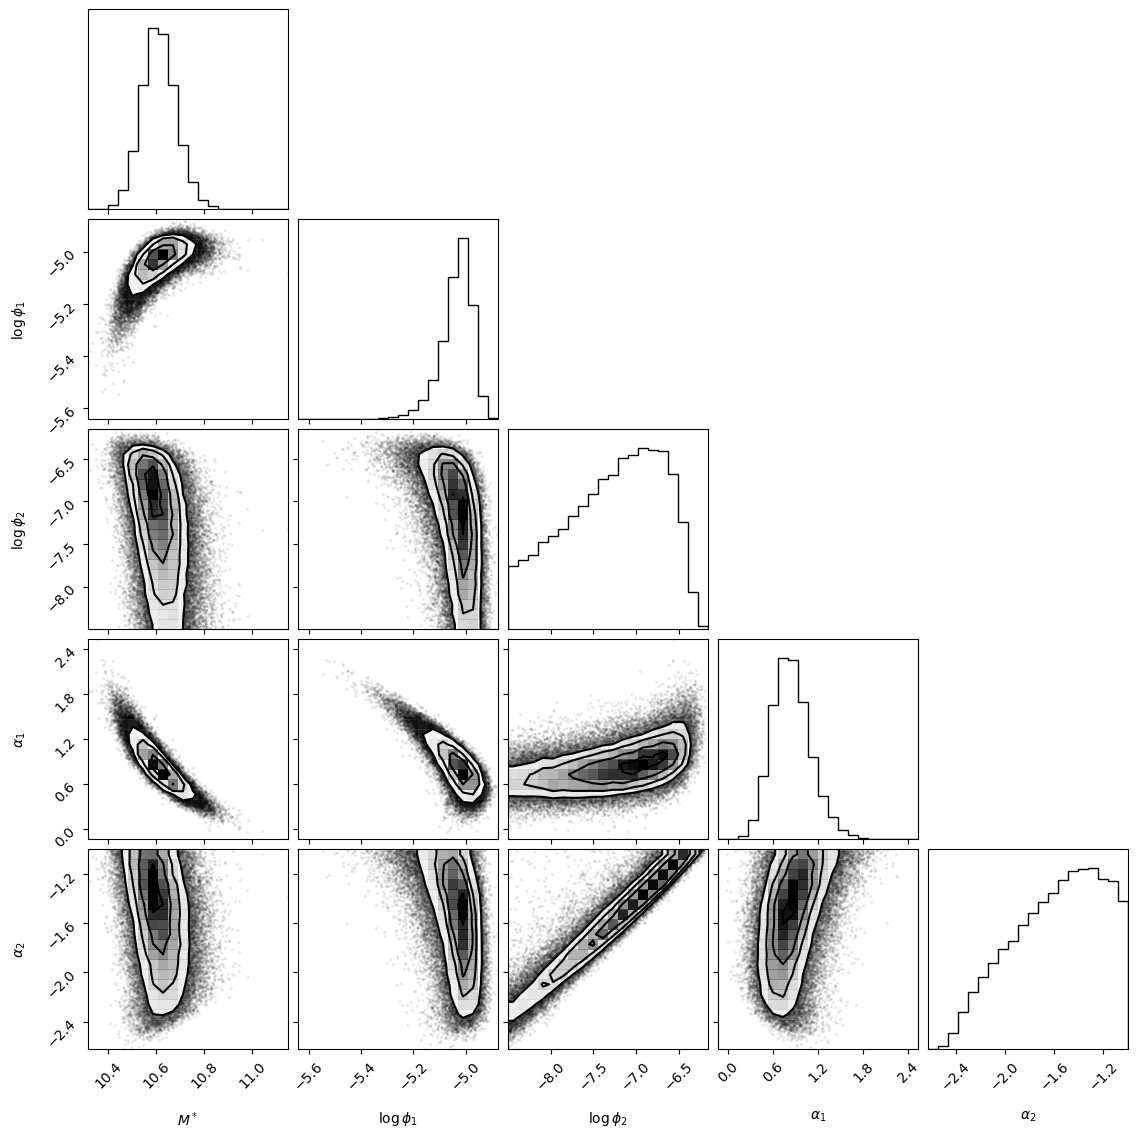

In [41]:
# membuat corner plot

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels)
fig.savefig('cornet_35_z_45.png')

In [42]:
# parameter hasil fitting

labels = [r'M^*', r'log{\phi_1}', r'log{\phi_2}', r'\alpha_1', r'\alpha_2']

result4 = []
result4_low = []
result4_high = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    result4.append(mcmc[1])
    result4_low.append(mcmc[0])
    result4_high.append(mcmc[2])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

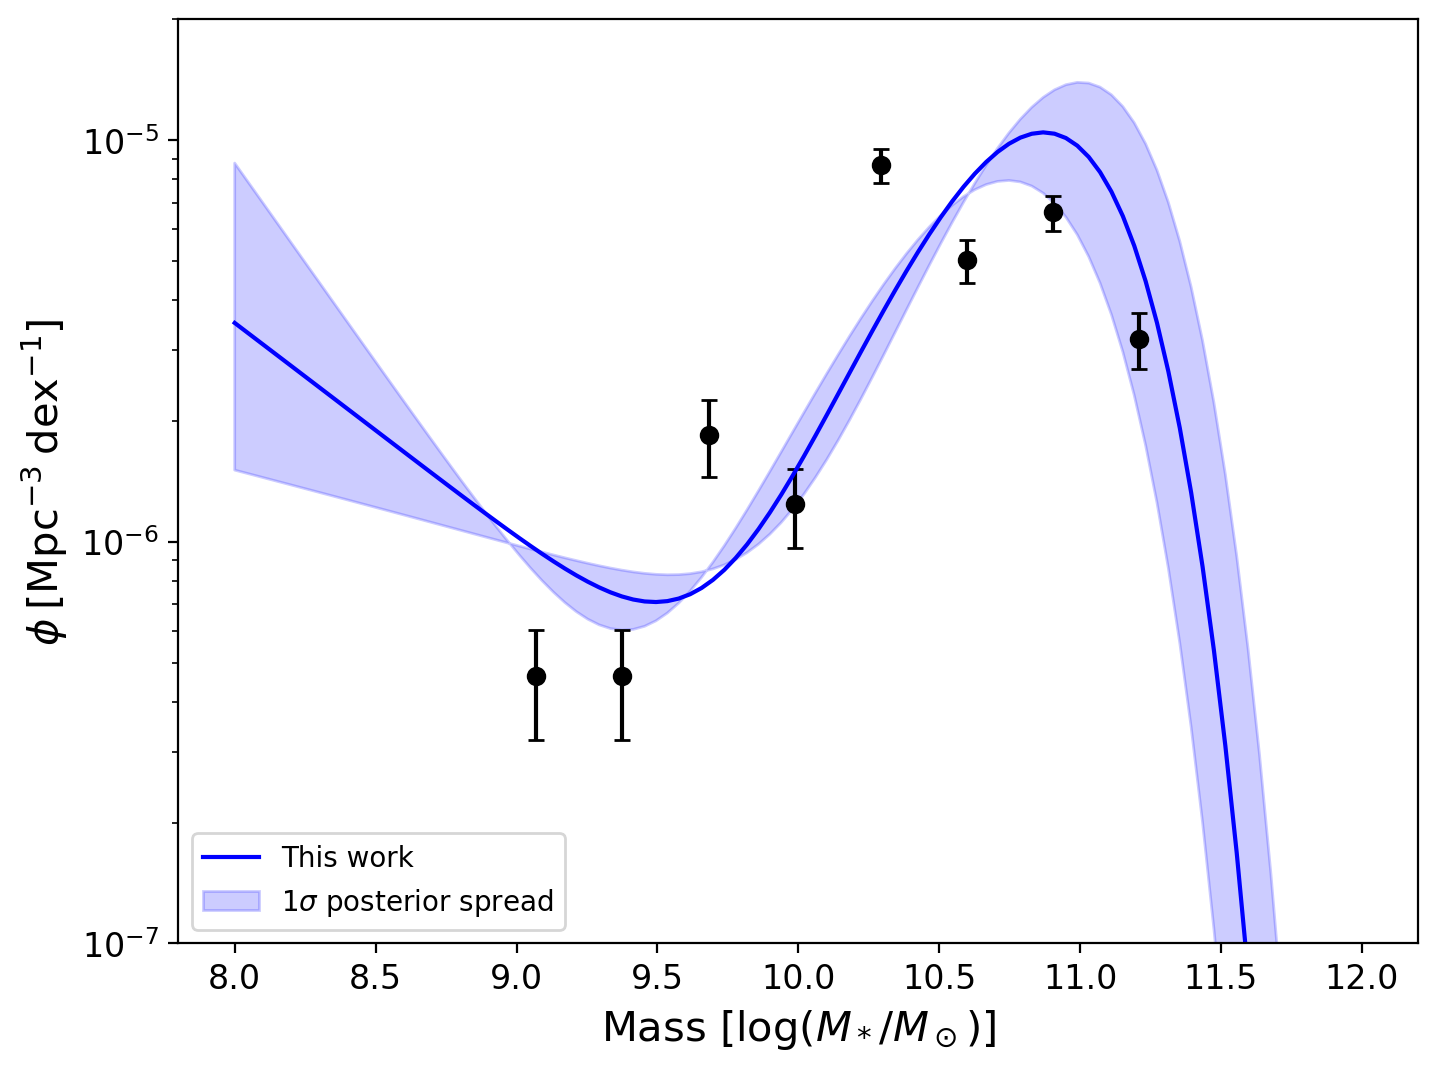

In [44]:
data = np.loadtxt('r3.5z4.5.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

plt.figure(figsize=(8,6), dpi = 200)

mass = np.linspace(8,12,100)
plt.errorbar(log_mass, phi, yerr=phi_err, fmt='o', capsize=3, markersize=6, linestyle='None', c = 'black')
plt.plot(mass,phi_func(mass, result4)[0], c = 'blue', linestyle='-',label='This work')
plt.fill_between(mass, phi_func(mass, result4_low)[0], phi_func(mass, result4_high)[0], color='blue', alpha=0.2, label=r'$1\sigma$ posterior spread')
plt.xlabel(r'Mass [log$(M_*/M_\odot)]$', size=15)

#plt.plot(mass, phi_func(mass, tes)[0])

plt.ylabel(r'$\phi\: [\text{Mpc}^{-3}\: \text{dex}^{-1}]$', size=15)
plt.tick_params(axis='both', which='both', labelsize=12)
plt.yscale('log')
plt.legend(loc='lower left')

plt.ylim(1e-7,2e-5)
plt.show()

## 4.0 < z < 5.5

In [50]:
data = np.loadtxt('r4.0z5.0.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

def lnprior(theta):
    #Mc, log_phi1, log_phi2, alpha1, alpha2, logf = theta
    Mc, log_phi1, log_phi2, alpha1, alpha2 = theta
    #if ( 9.5 < Mc < 12.0 ) & (log_phi2-log_phi1 < np.log10(0.5)) & (log_phi2 > -7) & ( -3.0 < alpha1 < 1.5) & ( -3.0 < alpha2 < -1 ) & ( -10.0 < logf < 10.0):
    if ( 9.5 < Mc < 12.0 ) & (log_phi2-log_phi1 < np.log10(0.5)) & (log_phi2 > -7.5) & ( -3.0 < alpha1 < 3.0) & ( -3.0 < alpha2 < -1.0 ):
        return 0.0
    else:
        return -np.inf
    
data = (log_mass, phi, phi_err)
nwalkers = 100
niter = 10000
initial = [10.54, (-3.92), (-6.88), 0.46, -1.30]
initial = result5
ndim = len(initial)

p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


100%|██████████████████████████████████| 100/100 [00:00<00:00, 164.98it/s]


Running production...


100%|██████████████████████████████| 10000/10000 [00:51<00:00, 194.74it/s]


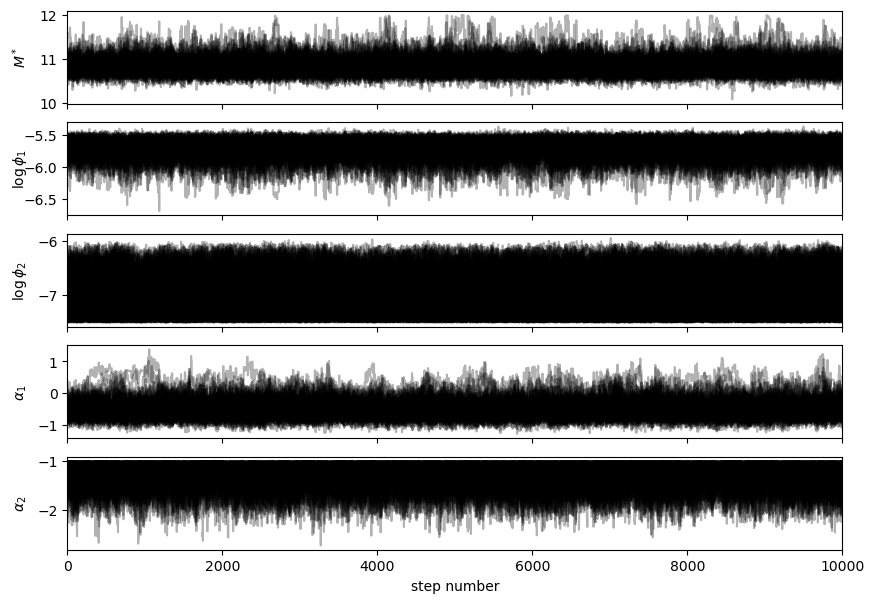

In [56]:
# membuat trace plot

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r'$M^*$', r'$\log{\phi_1}$', r'$\log{\phi_2}$', r'$\alpha_1$', r'$\alpha_2$']

for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number")
plt.savefig('rumput_4_z_55.png')

(66000, 5)


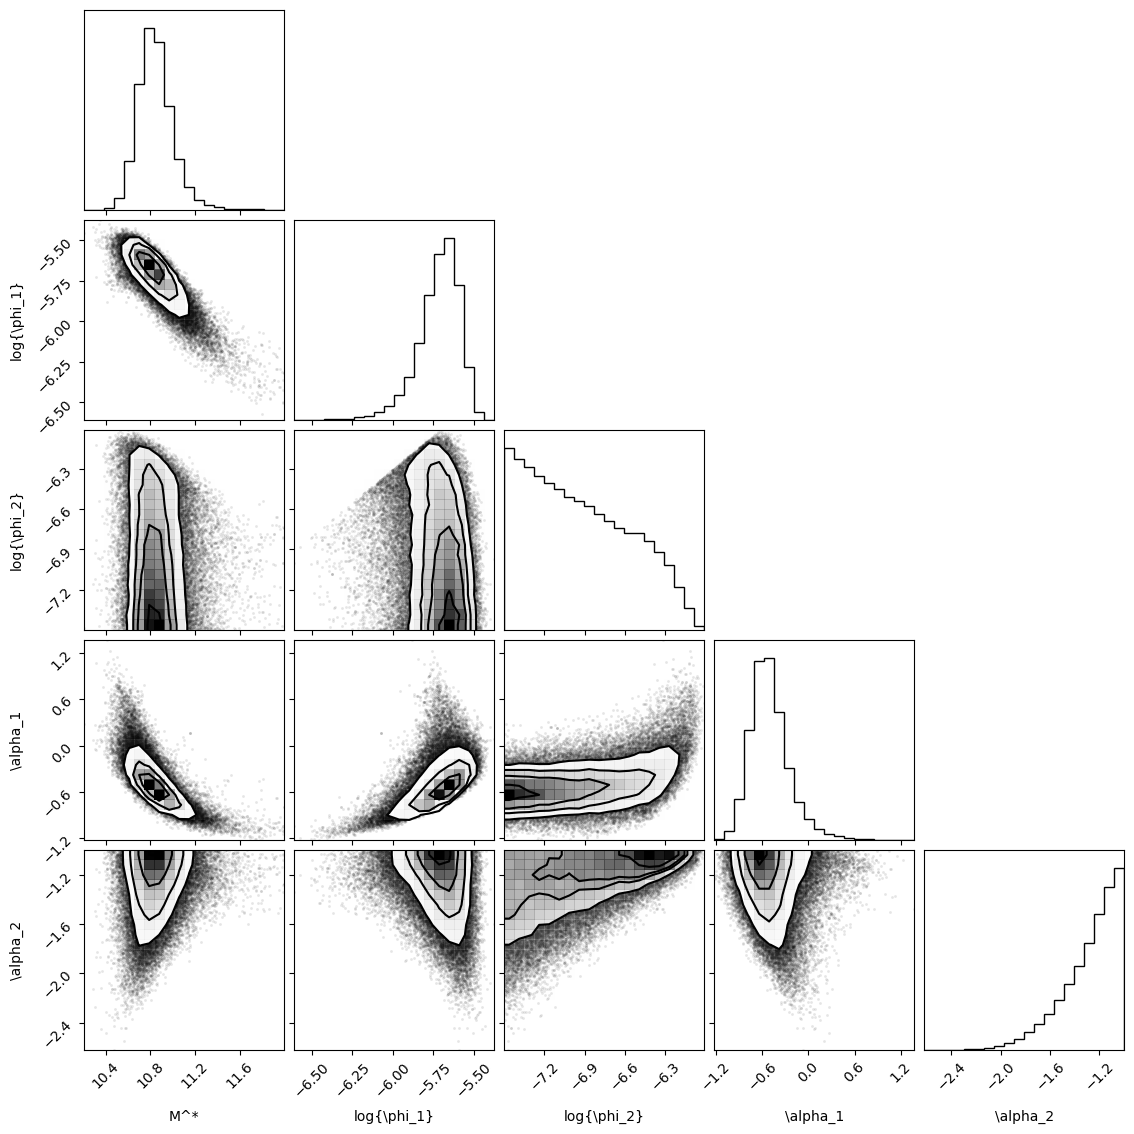

In [55]:
# membuat corner plot

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels)
fig.savefig('cornet_4_z_55.png')

In [53]:
# parameter hasil fitting

labels = [r'M^*', r'log{\phi_1}', r'log{\phi_2}', r'\alpha_1', r'\alpha_2']

result5 = []
result5_low = []
result5_high = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    result5.append(mcmc[1])
    result5_low.append(mcmc[0])
    result5_high.append(mcmc[2])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

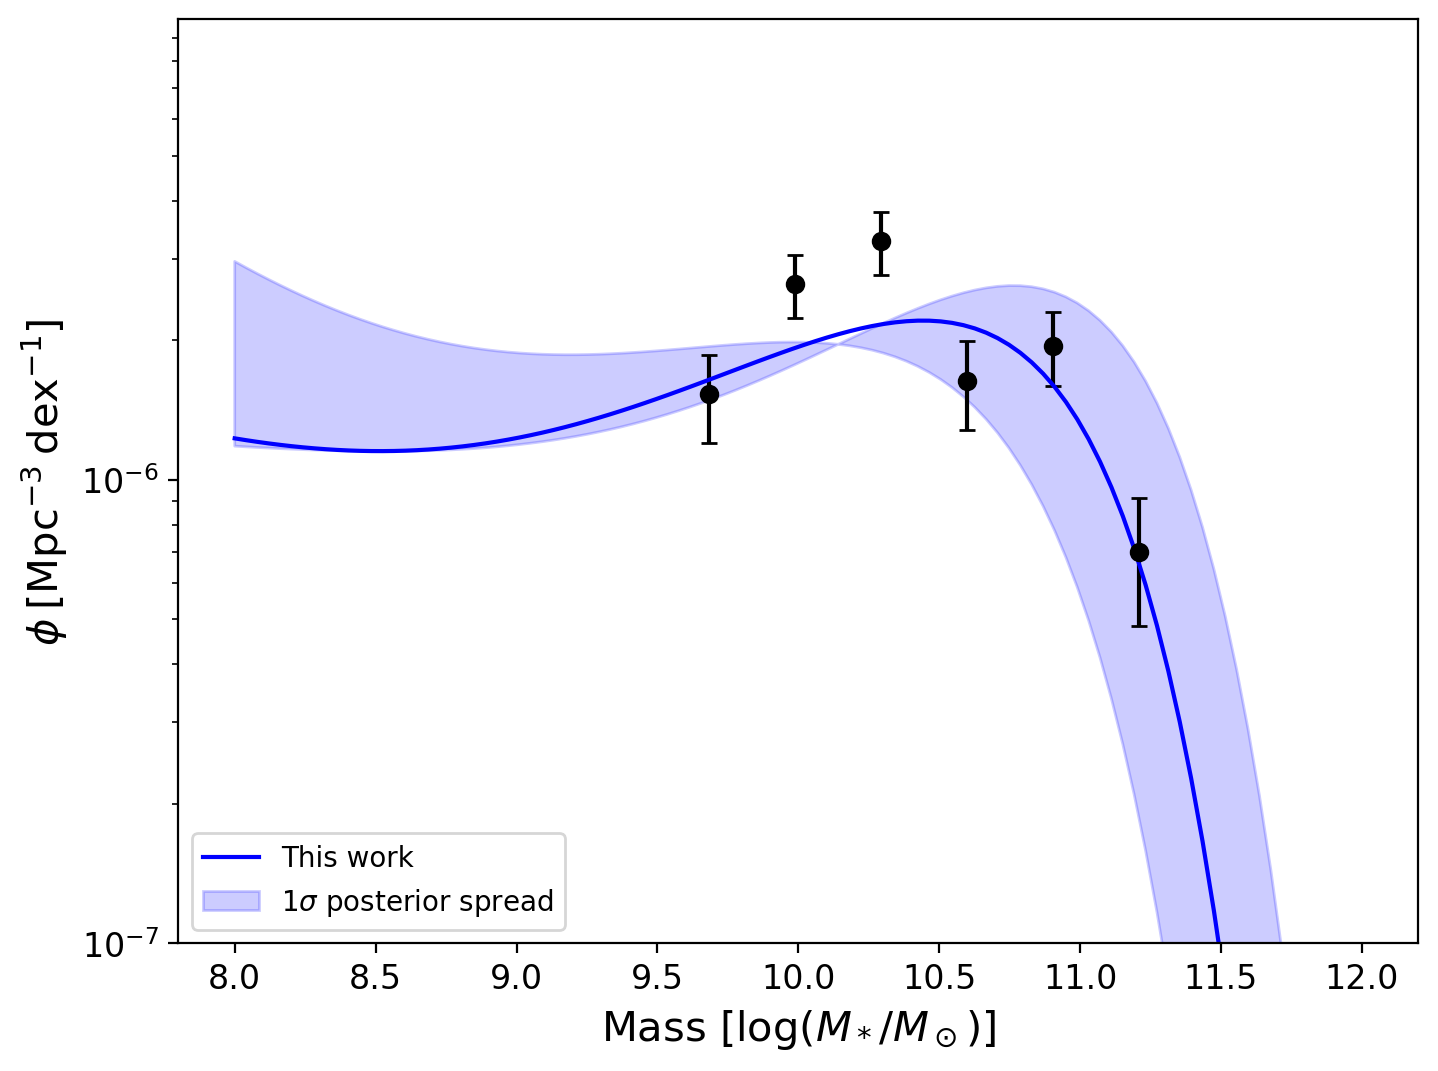

In [54]:
data = np.loadtxt('r4.0z5.0.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

plt.figure(figsize=(8,6), dpi = 200)

mass = np.linspace(8,12,100)
plt.errorbar(log_mass, phi, yerr=phi_err, fmt='o', capsize=3, markersize=6, linestyle='None', c = 'black')
plt.plot(mass,phi_func(mass, result5)[0], c = 'blue', linestyle='-',label='This work')
plt.fill_between(mass, phi_func(mass, result5_low)[0], phi_func(mass, result5_high)[0], color='blue', alpha=0.2, label=r'$1\sigma$ posterior spread')
plt.xlabel(r'Mass [log$(M_*/M_\odot)]$', size=15)
plt.ylabel(r'$\phi\: [\text{Mpc}^{-3}\: \text{dex}^{-1}]$', size=15)
plt.tick_params(axis='both', which='both', labelsize=12)
plt.yscale('log')
plt.legend(loc='lower left')
plt.ylim(1e-7,)
plt.show()

## 5.5 < z < 7.0

In [62]:
data = np.loadtxt('r5.0z7.0.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

def lnprior(theta):
    #Mc, log_phi1, log_phi2, alpha1, alpha2, logf = theta
    Mc, log_phi1, log_phi2, alpha1, alpha2 = theta
    #if ( 9.5 < Mc < 12.0 ) & (log_phi2-log_phi1 < np.log10(0.5)) & (log_phi2 > -7) & ( -3.0 < alpha1 < 1.5) & ( -3.0 < alpha2 < -1 ) & ( -10.0 < logf < 10.0):
    if ( 9.5 < Mc < 12.0 ) & (log_phi2-log_phi1 < np.log10(0.5)) & (log_phi2 > -7.5) & ( -3.0 < alpha1 < 1.5) & ( -3.0 < alpha2 < -1.0 ):
        return 0.0
    else:
        return -np.inf
    
data = (log_mass, phi, phi_err)
nwalkers = 100
niter = 10000
initial = [10.54, (-3.92), (-6.88), 0.46, -1.30]
initial = result6
ndim = len(initial)

p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


100%|██████████████████████████████████| 100/100 [00:00<00:00, 160.01it/s]


Running production...


100%|██████████████████████████████| 10000/10000 [00:53<00:00, 187.13it/s]


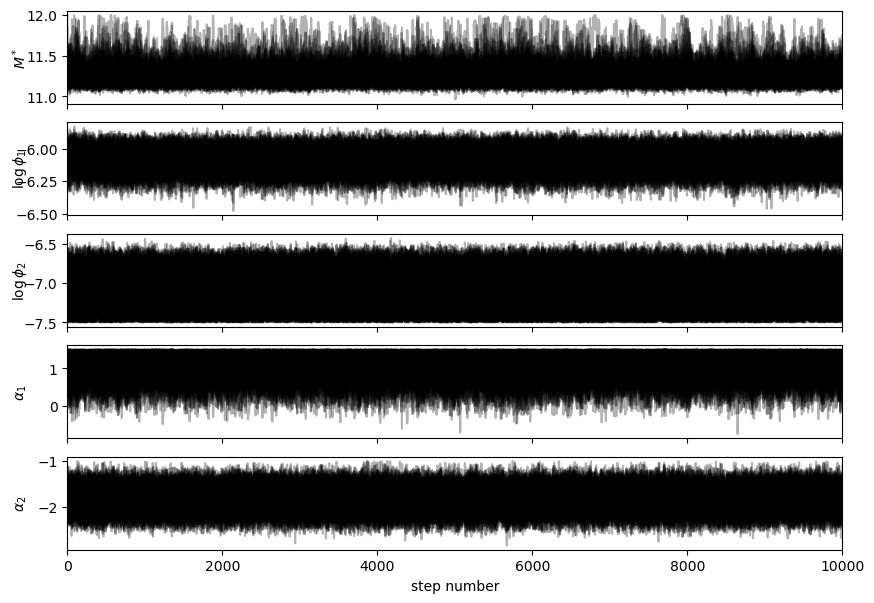

In [67]:
# membuat trace plot

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
#labels = [r'$M^*$', r'$\log{\phi_1}$', r'$\log{\phi_2}$', r'$\alpha_1$', r'$\alpha_2$', r'$\log{f}$']
labels = [r'$M^*$', r'$\log{\phi_1}$', r'$\log{\phi_2}$', r'$\alpha_1$', r'$\alpha_2$']

for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number")
plt.savefig('rumput_55_z_7.png')

(66000, 5)


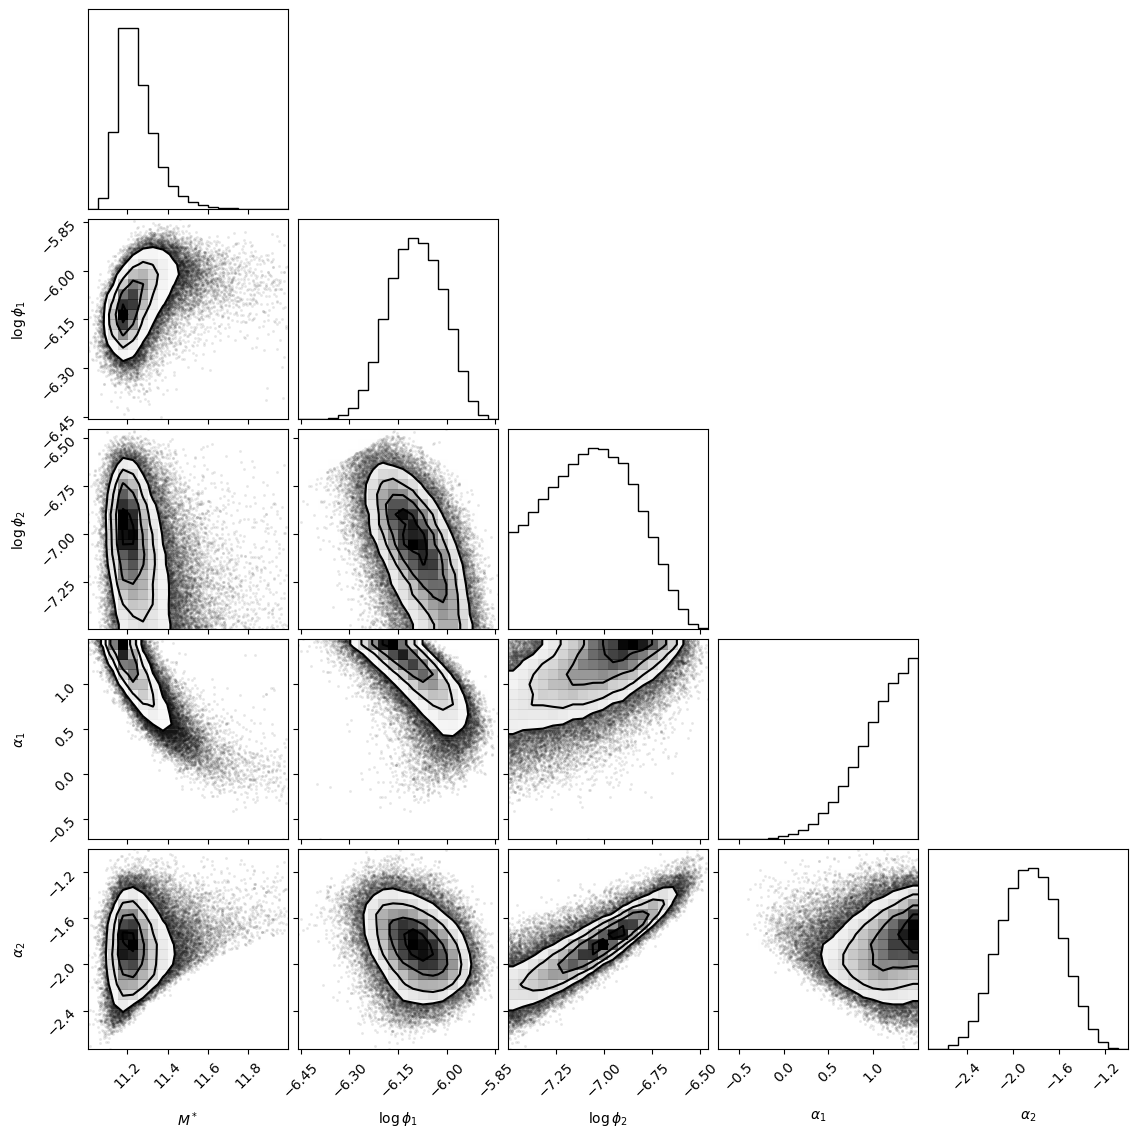

In [68]:
# membuat corner plot

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels)
fig.savefig('cornet_55_z_7.png')

In [65]:
# parameter hasil fitting

labels = [r'M^*', r'log{\phi_1}', r'log{\phi_2}', r'\alpha_1', r'\alpha_2']

result6 = []
result6_low = []
result6_high = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    result6.append(mcmc[1])
    result6_low.append(mcmc[0])
    result6_high.append(mcmc[2])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

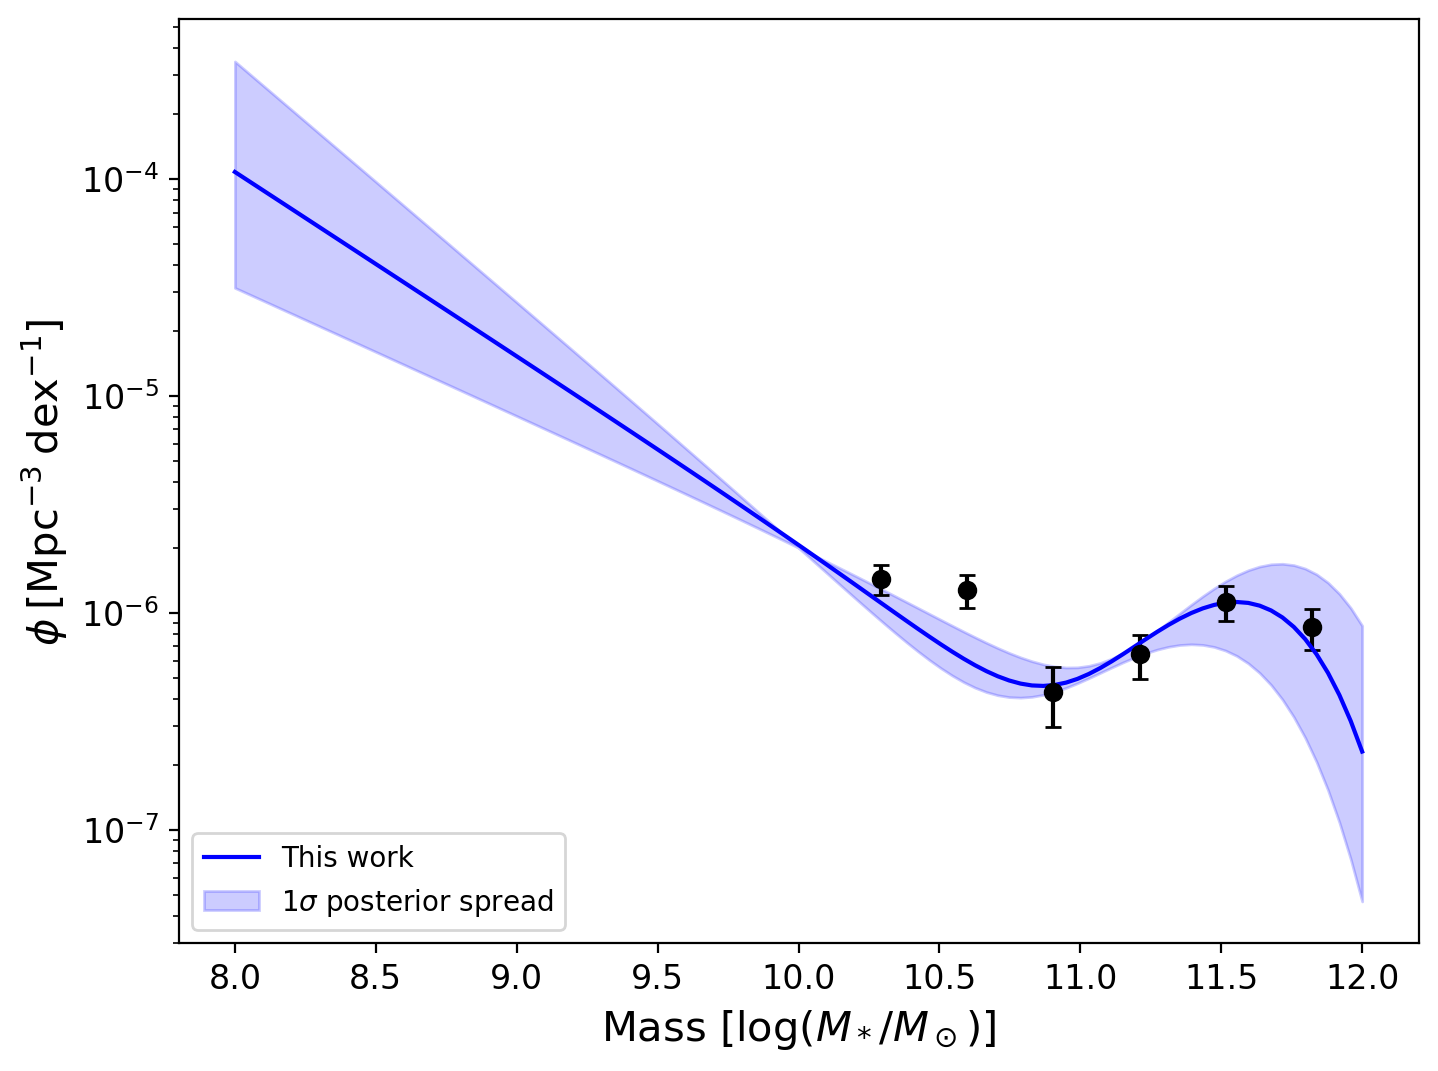

In [66]:
data = np.loadtxt('r5.5z7.0.txt')

phi = data[:,1]
log_mass = data[:,0]
phi_err = data[:,2]

plt.figure(figsize=(8,6), dpi = 200)

mass = np.linspace(8,12,100)
plt.errorbar(log_mass, phi, yerr=phi_err, fmt='o', capsize=3, markersize=6, linestyle='None', c = 'black')
plt.plot(mass,phi_func(mass, result6)[0], c = 'blue', linestyle='-',label='This work')
plt.fill_between(mass, phi_func(mass, result6_low)[0], phi_func(mass, result6_high)[0], color='blue', alpha=0.2, label=r'$1\sigma$ posterior spread')
plt.xlabel(r'Mass [log$(M_*/M_\odot)]$', size=15)
plt.ylabel(r'$\phi\: [\text{Mpc}^{-3}\: \text{dex}^{-1}]$', size=15)
plt.tick_params(axis='both', which='both', labelsize=12)
plt.yscale('log')
plt.legend(loc='lower left')
plt.show()

## Combined

In [69]:
result_list = np.array([result2, result3, result4, result5, result6])
result_low_list = np.array([result2_low, result3_low, result4_low, result5_low, result6_low])
result_high_list = np.array([result2_high, result3_high, result4_high, result5_high, result6_high])

data1 = np.loadtxt('r2.0z2.5.txt')
data2 = np.loadtxt('r2.5z3.0.txt')
data3 = np.loadtxt('r3.0z3.5.txt')
data4 = np.loadtxt('r3.5z4.0.txt')
data5 = np.loadtxt('r4.0z5.0.txt')
data6 = np.loadtxt('r5.0z7.0.txt')

data_arr = ([data2, data3, data4, data5, data6])

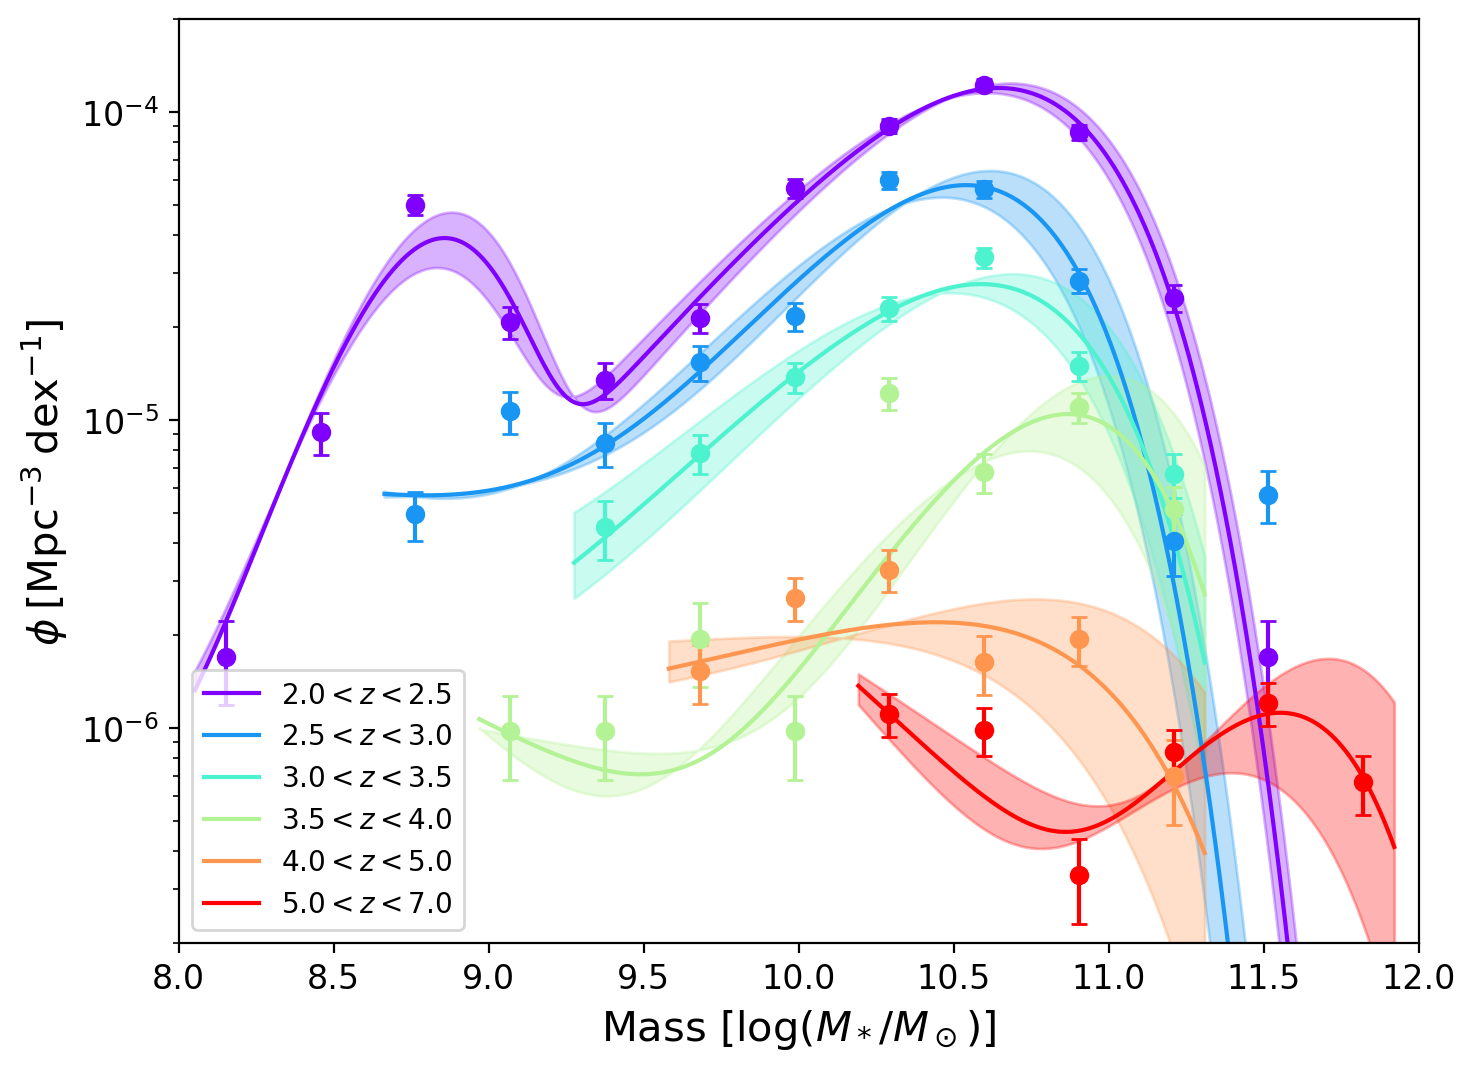

In [70]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(result_list)+1))

z_range = np.array([[2.5,3.0], [3.0,3.5], [3.5,4.0], [4.0,5.0], [5.0,7.0]])
plt.figure(figsize=(8,6), dpi=200)

mass = np.linspace(data1[:,0].min()-0.1,data1[:,0].max()+0.1,1000)
plt.plot(mass, phi_func_double(mass,resultcom)[0], c = colors[0], linestyle='-', label=r'$2.0<z<2.5$')   
plt.errorbar(data1[:,0], data1[:,1], yerr=data1[:,2], fmt='o', capsize=3, markersize=6, linestyle='None', c = colors[0])
plt.fill_between(mass, phi_func_double(mass, resultcom_low)[0], phi_func_double(mass, resultcom_high)[0], color=colors[0], alpha=0.3)

for i in range(len(result_list)):
    z_low = z_range[i][0]
    z_high = z_range[i][1]
    mass = np.linspace(data_arr[i][:,0].min()-0.1,data_arr[i][:,0].max()+0.1,1000)
    plt.plot(mass,phi_func(mass, result_list[i])[0], c = colors[i+1], linestyle='-',label=r'${}<z<{}$'.format(z_low,z_high))
    plt.fill_between(mass, phi_func(mass, result_low_list[i])[0], phi_func(mass, result_high_list[i])[0], color=colors[i+1], alpha=0.3)
    plt.errorbar(data_arr[i][:,0], data_arr[i][:,1], yerr=data_arr[i][:,2], fmt='o', capsize=3, markersize=6, linestyle='None', c = colors[i+1])

plt.xlabel(r'Mass [log$(M_*/M_\odot)]$', size=15)
plt.ylabel(r'$\phi\: [\text{Mpc}^{-3}\: \text{dex}^{-1}]$', size=15)
plt.tick_params(axis='both', which='both', labelsize=12)
plt.yscale('log')
plt.legend(loc='lower left')
plt.xlim(8,12)
plt.ylim(2e-7,2e-4)
plt.show()

# Evolution of Stellar Mass Density

In [71]:
logM = np.linspace(8,13,100)
rho_list = []
for i in range(len(result_list)):
    rho = np.trapz(phi_func(logM, result_list[i]), 10**logM)
    rho_list.append(rho)
    
rho_list = np.array(rho_list)

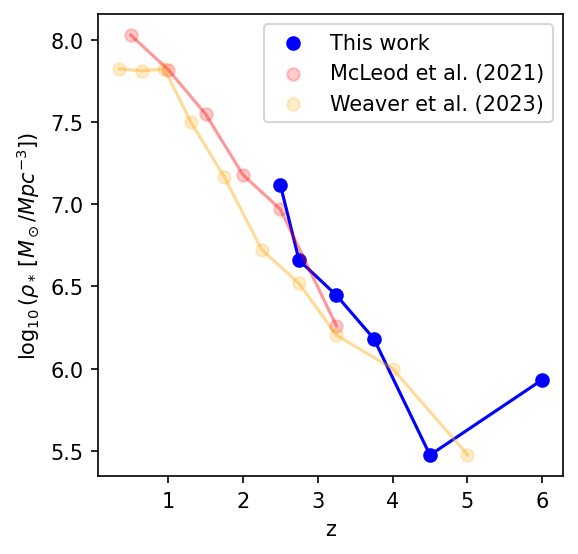

In [72]:
plt.figure(figsize=(4,4), dpi=150)

rho_z_25 = np.trapz(phi_func_double(logM, resultcom), 10**logM)

z_ref = [0.5, 1.0, 1.5, 2.0, 2.5, 3.25]
rho_ref = [8.03, 7.82, 7.55, 7.18, 6.97, 6.26]

z_ref1 = [0.35, 0.65, 0.95, 1.3, 1.75, 2.25, 2.75, 3.25, 4.0, 5.0]
rho_ref1 = np.log10(np.array([6.68, 6.49, 6.67, 3.19, 1.47, 0.53, 0.33, 0.16, 0.10, 0.03])*1e7)

z_plot = np.concatenate((np.array([2.5]), np.mean(z_range,1)))
rho_plot = np.concatenate((np.array(np.log10(rho_z_25)), np.transpose(np.log10(rho_list))[0]))

plt.scatter(z_plot, rho_plot, c = 'blue', label='This work')
plt.plot(z_plot, rho_plot, c = 'blue')

plt.scatter(z_ref, rho_ref, c = 'red', label='McLeod et al. (2021)', alpha=0.2)
plt.plot(z_ref, rho_ref, c = 'red', alpha=0.4)

plt.scatter(z_ref1, rho_ref1, c = 'orange', label='Weaver et al. (2023)', alpha=0.2)
plt.plot(z_ref1, rho_ref1, c = 'orange', alpha=0.4)

plt.xlabel('z')
plt.ylabel(r'$\log_{10}(\rho_*\: [M_\odot/Mpc^{-3}])$')
plt.legend()